In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, f1_score, 
                             precision_score, recall_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt


# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Función para preprocesar texto
def preprocess_text(text_series):
    text_series = text_series.str.replace(r'http\S+', '', regex=True)  # Eliminar URLs
    text_series = text_series.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Eliminar caracteres especiales
    text_series = text_series.str.replace(r'\s+', ' ', regex=True)  # Reemplazar múltiples espacios por uno
    return text_series.str.lower().str.strip()

# Cargar datasets
train_data = pd.read_csv("divisonDatos/train_data.csv", sep=";")
val_data = pd.read_csv("divisonDatos/val_data.csv", sep=";")
test_data = pd.read_csv("divisonDatos/test_data.csv", sep=";")

test_data


Usando dispositivo: cuda


,Label,Texto
0,0,nueva ley económica el gobierno presenta un pr...
1,1,presidente el psoe se erigió como gran enemigo...
2,0,boluarte se aferra al bloqueo de un cgpj de ma...
3,1,sigue en directo el debate electoral entre los...
4,0,15 de abril de 2024 se celebra el día internac...
...,...,...
11137,0,iniciativa vers per catalunya cs y coalición c...
11138,0,cristina narbona promete despenalizar la eutan...
11139,1,òmnium cree que cristina narbona debe aceptar ...
11140,0,cristina narbona se reivindica ante la extrema...


In [3]:
resultado = test_data[test_data['Texto'].str.contains("Ecuador", na=False)]

# Si quieres ignorar mayúsculas/minúsculas en la búsqueda:
resultado_case_insensitive = test_data[test_data['Texto'].str.contains("Ecuador", case=False, na=False)]

print(resultado)

Empty DataFrame
Columns: [Label, Texto]
Index: []


Epoch 0/5000, Loss: 1.0393, Val Loss: 1.0392
Epoch 10/5000, Loss: 1.0376, Val Loss: 1.0379
Epoch 20/5000, Loss: 1.0368, Val Loss: 1.0372
Epoch 30/5000, Loss: 1.0363, Val Loss: 1.0367
Epoch 40/5000, Loss: 1.0358, Val Loss: 1.0363
Epoch 50/5000, Loss: 1.0355, Val Loss: 1.0360
Epoch 60/5000, Loss: 1.0351, Val Loss: 1.0356
Epoch 70/5000, Loss: 1.0348, Val Loss: 1.0354
Epoch 80/5000, Loss: 1.0345, Val Loss: 1.0351
Epoch 90/5000, Loss: 1.0343, Val Loss: 1.0349
Epoch 100/5000, Loss: 1.0340, Val Loss: 1.0346
Epoch 110/5000, Loss: 1.0338, Val Loss: 1.0344
Epoch 120/5000, Loss: 1.0336, Val Loss: 1.0342
Epoch 130/5000, Loss: 1.0334, Val Loss: 1.0341
Epoch 140/5000, Loss: 1.0332, Val Loss: 1.0339
Epoch 150/5000, Loss: 1.0330, Val Loss: 1.0337
Epoch 160/5000, Loss: 1.0329, Val Loss: 1.0336
Epoch 170/5000, Loss: 1.0327, Val Loss: 1.0334
Epoch 180/5000, Loss: 1.0326, Val Loss: 1.0333
Epoch 190/5000, Loss: 1.0324, Val Loss: 1.0331
Epoch 200/5000, Loss: 1.0323, Val Loss: 1.0330
Epoch 210/5000, Loss: 1.

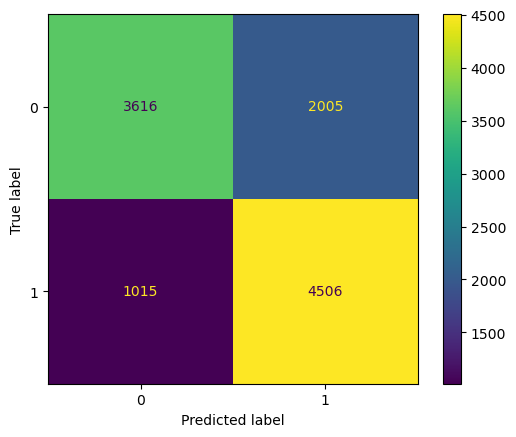

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, f1_score, 
                             precision_score, recall_score, 
                             confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------
# 1) Lectura y Preprocesamiento de Datos
# --------------------------------------------------------------------------------------

# EJEMPLO: supongamos que ya tienes 3 dataframes: train_data, val_data, test_data
# con columnas ["Texto", "Label"]. Cada uno es un DataFrame de pandas.

# Por ejemplo (placeholder):
# train_data = pd.read_csv("train.csv")
# val_data   = pd.read_csv("val.csv")
# test_data  = pd.read_csv("test.csv")

# Asegúrate de que en train_data, val_data, test_data existan columnas
# "Texto" (string) y "Label" (0 o 1).

# Función de preprocesamiento (básica: lower y strip). Mejórala según necesites.
def preprocess_text(series):
    """
    Recibe una Series de pandas con texto y retorna otra Series preprocessada.
    """
    return series.str.lower().str.strip()

# Aplica la función de preprocesamiento a las columnas de texto
train_data['Texto'] = preprocess_text(train_data['Texto'])
val_data['Texto']   = preprocess_text(val_data['Texto'])
test_data['Texto']  = preprocess_text(test_data['Texto'])

# --------------------------------------------------------------------------------------
# 2) Vectorización con TF-IDF
# --------------------------------------------------------------------------------------
vectorizer = TfidfVectorizer(
    max_features=30000, 
    ngram_range=(1, 2), 
    stop_words='english'
)

X_train = vectorizer.fit_transform(train_data['Texto']).toarray()
X_val   = vectorizer.transform(val_data['Texto']).toarray()
X_test  = vectorizer.transform(test_data['Texto']).toarray()

y_train = train_data['Label'].values
y_val   = val_data['Label'].values
y_test  = test_data['Label'].values

# --------------------------------------------------------------------------------------
# 3) Cálculo de pesos de clase y conversión a tensores
# --------------------------------------------------------------------------------------
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights *= 1.5  # Ajuste manual
# class_weights es un array, lo convertimos a tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Convertir features y labels a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor   = torch.tensor(X_val,   dtype=torch.float32).to(device)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor   = torch.tensor(y_val,   dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32).view(-1, 1).to(device)

# --------------------------------------------------------------------------------------
# 4) Creación de DataLoaders
# --------------------------------------------------------------------------------------
batch_size = 128

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --------------------------------------------------------------------------------------
# 5) Definición del Modelo de Regresión Logística en PyTorch
# --------------------------------------------------------------------------------------
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Activación sigmoide para salida binaria
        return torch.sigmoid(self.fc(x))

# Inicializar el modelo
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim).to(device)

# Función auxiliar para inicializar pesos
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# --------------------------------------------------------------------------------------
# 6) Definir la función de pérdida (BCELoss sin reducción, para aplicar pesos)
# --------------------------------------------------------------------------------------
criterion = nn.BCELoss(reduction='none')

# --------------------------------------------------------------------------------------
# 7) Implementación manual de Adagrad
# --------------------------------------------------------------------------------------
class ManualAdagrad:
    def __init__(self, model_parameters, lr=1e-4, weight_decay=1e-2, eps=1e-8):
        self.params = list(model_parameters)  # lista de parámetros del modelo
        self.lr = lr
        self.weight_decay = weight_decay
        self.eps = eps
        
        # Diccionario para almacenar la suma de cuadrados de gradientes de cada parámetro
        self.accumulators = {}
        for p in self.params:
            # Igual shape que p.data, inicializado a cero
            self.accumulators[p] = torch.zeros_like(p.data, device=p.data.device)
    
    def step(self):
        """Actualiza los parámetros según la regla de Adagrad."""
        for p in self.params:
            if p.grad is None:
                continue
            
            # Aplicar regularización L2 directamente al gradiente
            p.grad.data.add_(p.data, alpha=self.weight_decay)

            # Sumar el cuadrado del gradiente al acumulador
            self.accumulators[p] += p.grad.data ** 2

            # Denominador para la actualización
            denom = torch.sqrt(self.accumulators[p]) + self.eps
            
            # Regla de Adagrad
            p.data = p.data - self.lr * (p.grad.data / denom)
    
    def zero_grad(self):
        """Pone a cero los gradientes."""
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

# Creamos nuestro "optimizador" Adagrad manual
manual_adagrad = ManualAdagrad(model.parameters(), lr=0.0001, weight_decay=0.01, eps=1e-8)

# --------------------------------------------------------------------------------------
# 8) Early Stopping
# --------------------------------------------------------------------------------------
class EarlyStopping:
    def __init__(self, patience=30, delta=0.0001):
        """
        :param patience: cuántas épocas consecutivas se permite que no mejore la val_loss.
        :param delta: pequeña mejora mínima considerada.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True
        return self.stop_training

# --------------------------------------------------------------------------------------
# 9) Función de entrenamiento con Adagrad manual
# --------------------------------------------------------------------------------------
def train_model_manual_adagrad(model, train_loader, criterion, manual_adagrad, 
                               val_loader, class_weights, n_epochs=2000):
    """
    Entrena el modelo usando una implementación manual de Adagrad.
    """
    early_stopping = EarlyStopping(patience=30, delta=0.0001)
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.0
        
        # -- Modo entrenamiento --
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 1) Reiniciar gradientes
            manual_adagrad.zero_grad()

            # 2) Forward
            outputs = model(inputs)
            labels = labels.view(-1, 1)
            loss = criterion(outputs, labels)  # BCELoss con shape (batch_size,)

            # Aplicar pesos de clase
            weights = torch.where(labels == 1, class_weights[1], class_weights[0])
            loss = (loss * weights).mean()

            # 3) Backward
            loss.backward()

            # 4) Actualizar parámetros con Adagrad manual
            manual_adagrad.step()
            
            running_loss += loss.item()

        # -- Validación --
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.view(-1, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                weights = torch.where(labels == 1, class_weights[1], class_weights[0])
                val_loss += (loss * weights).mean().item()

        avg_val_loss = val_loss / len(val_loader)

        # Early stopping
        if early_stopping(avg_val_loss):
            print(f"Early stopping en la época {epoch}")
            break

        if epoch % 10 == 0:
            avg_train_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch}/{n_epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        model.train()  # volver a modo entrenamiento

# --------------------------------------------------------------------------------------
# 10) Entrenar el modelo
# --------------------------------------------------------------------------------------
train_model_manual_adagrad(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    manual_adagrad=manual_adagrad,
    val_loader=val_loader,
    class_weights=class_weights,
    n_epochs=5000
)

# --------------------------------------------------------------------------------------
# 11) Ajustar umbral dinámicamente y evaluar
# --------------------------------------------------------------------------------------
def evaluate_model(model, data_loader, threshold=0.5):
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs >= threshold).float()
            y_pred.extend(predictions.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred = np.array(y_pred).flatten()
    y_true = np.array(y_true).flatten()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    return acc, f1, precision, recall

def find_best_threshold(model, val_loader):
    thresholds = np.linspace(0.1, 0.9, 100)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        acc, f1, precision, recall = evaluate_model(model, val_loader, threshold=threshold)
        # Si precisión y recall son > 0.75 y f1 es mejor que lo visto hasta ahora, actualizamos
        if precision > 0.75 and recall > 0.75 and f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold

best_threshold = find_best_threshold(model, val_loader)
print(f"Mejor umbral encontrado: {best_threshold:.4f}")

# Evaluación en validación
acc, f1, precision, recall = evaluate_model(model, val_loader, threshold=best_threshold)
print(f"Evaluación en validación: Acc={acc:.4f}, F1={f1:.4f}, Precisión={precision:.4f}, Recall={recall:.4f}")

# Evaluación en test
acc, f1, precision, recall = evaluate_model(model, test_loader, threshold=best_threshold)
print(f"Evaluación en test:      Acc={acc:.4f}, F1={f1:.4f}, Precisión={precision:.4f}, Recall={recall:.4f}")

# --------------------------------------------------------------------------------------
# 12) Visualizar matriz de confusión en Test
# --------------------------------------------------------------------------------------
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

y_pred, y_true = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = (outputs >= best_threshold).float()
        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

plot_confusion_matrix(np.array(y_true).flatten(), np.array(y_pred).flatten())
